In [1]:
%load_ext autoreload
%autoreload 2

# Visualization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, TwoByTwoLayout
from data import InstanceLoader

In [3]:
def maskImg(img, threshold):
    mask = img.copy()
    mask[mask <= threshold] = np.nan
    return mask

def f(x, ct, oar, ptv, dose, dose_threshold=0):
    fig, axarr = plt.subplots(1,1, figsize=(15, 8))
    
    if ct is not None and x < ct.shape[-1]:
        axarr.imshow(ct[:,:,x], cmap='viridis', interpolation='None')
    if oar is not None and x < oar.shape[-1]:
        axarr.imshow(maskImg(oar[:,:,x], 0), alpha=0.5, cmap='spring', interpolation='None')
    if ptv is not None and x < ptv.shape[-1]:
        axarr.imshow(maskImg(ptv[:,:,x], 0), alpha=0.8, cmap='bone', interpolation='None')
    if dose is not None and x < dose.shape[-1]:
        axarr.imshow(maskImg(dose[:,:,x], dose_threshold), alpha=0.5, cmap='hot', interpolation='None')

    plt.show()

def f2(x, ct, oar, ptv, dose, ct2, oar2, ptv2, dose2, dose_threshold=0, dose_threshold2=0):
    fig, axarr = plt.subplots(1,2, figsize=(15, 8))
    
    if ct is not None and x < ct.shape[-1]:
        axarr[0].imshow(ct[:,:,x], cmap='viridis', interpolation='None')
    if oar is not None and x < oar.shape[-1]:
        axarr[0].imshow(maskImg(oar[:,:,x], 0), alpha=0.5, cmap='spring', interpolation='None')
    if ptv is not None and x < ptv.shape[-1]:
        axarr[0].imshow(maskImg(ptv[:,:,x], 0), alpha=0.8, cmap='bone', interpolation='None')
    if dose is not None and x < dose.shape[-1]:
        axarr[0].imshow(maskImg(dose[:,:,x], dose_threshold), alpha=0.5, cmap='hot', interpolation='None')

    if ct2 is not None and x < ct2.shape[-1]:
        axarr[1].imshow(ct2[:,:,x], cmap='viridis', interpolation='None')
    if oar2 is not None and x < oar2.shape[-1]:
        axarr[1].imshow(maskImg(oar2[:,:,x], 0), alpha=0.5, cmap='spring', interpolation='None')
    if ptv2 is not None and x < ptv2.shape[-1]:
        axarr[1].imshow(maskImg(ptv2[:,:,x], 0), alpha=0.8, cmap='bone', interpolation='None')
    if dose2 is not None and x < dose2.shape[-1]:
        axarr[1].imshow(maskImg(dose2[:,:,x], dose_threshold2), alpha=0.5, cmap='hot', interpolation='None')
        
    plt.show()

## Viz

In [23]:
out_dir = 'C:/Users/joao/Desktop/tese/datasets/Pancreatic/Pancreatic-Preprocessed'
viz_instance_loader = InstanceLoader(out_dir,batch_size=1)
batch = viz_instance_loader.getCase(1)

Instance size: 20
Train size: 16
Test size: 4


In [16]:
dose.any()

True

In [24]:
image = batch['CT']
struct = batch['PTV']
oar = batch['OAR']
dose = batch['DOSE']
biggest = np.max([image.shape[-1], struct.shape[-1], oar.shape[-1], dose.shape[-1]])
interact(f, x=(0, biggest-1), ct=fixed(image), oar=fixed(oar), ptv=fixed(struct), dose=fixed(dose), dose_threshold=fixed(0.5))

interactive(children=(IntSlider(value=228, description='x', max=456), Output()), _dom_classes=('widget-interac…

<function __main__.f(x, ct, oar, ptv, dose, dose_threshold=0)>

## Preprocessing

In [7]:
import data

In [15]:
ct = 'C:/Users/joao/Desktop/tese/datasets/Pancreatic/Pancreatic-CT-CBCT-SEG/Pancreas-CT-CB_001/07-06-2012-NA-PANCREAS-59677/201.000000-PANCREAS DI iDose 3-97846'
ct2 = 'C:/Users/joao/Desktop/tese/datasets/Pancreatic/Pancreatic-CT-CBCT-SEG/Pancreas-CT-CB_001/07-06-2012-NA-PANCREAS-59677/56094.000000-Aligned resampled CB02-39781'
dose = 'C:/Users/joao/Desktop/tese/datasets/Pancreatic/Pancreatic-CT-CBCT-SEG/Pancreas-CT-CB_001/07-06-2012-NA-PANCREAS-59677/321.000000-Eclipse Doses-94184'
cts = data.read_dicoms(ct)
cts2 = data.read_dicoms(ct2)
doses = data.read_dicoms(dose)

In [16]:
print(cts.shape, cts2.shape, doses.shape)

(512, 512, 134) (512, 512, 134) (226, 384, 269)


In [ ]:
biggest = np.max([cts.shape[-1], doses.shape[-1]])
interact(f, x=(0, biggest-1), ct=fixed(cts), oar=fixed(None), ptv=fixed(None), dose=fixed(doses), dose_threshold=fixed(0))

In [19]:
filep = np.load('C:/Users/joao/Desktop/tese/datasets/Pancreatic/Pancreatic-Preprocessed2/case0.npz')

In [20]:
image = filep['CT']
dose = filep['DOSE']

In [22]:
biggest = np.max([image.shape[-1], dose.shape[-1]])
interact(f, x=(0, biggest-1), ct=fixed(image), oar=fixed(None), ptv=fixed(None), dose=fixed(dose), dose_threshold=fixed(0.5))

interactive(children=(IntSlider(value=134, description='x', max=268), Output()), _dom_classes=('widget-interac…

<function __main__.f(x, ct, oar, ptv, dose, dose_threshold=0)>

# Training

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pickle

from data import InstanceLoader
from model import Unet
import metrics

In [26]:
instance_dir = 'C:/Users/joao/Desktop/tese/datasets/Pancreatic/Pancreatic-Preprocessed'
checkpoint_path = 'C:/Users/joao/Desktop/tese/Projeto/models/'

In [27]:
instance_loader = InstanceLoader(instance_dir)
instance_shape = instance_loader.shape()
print(instance_shape)

Instance size: 20
Train size: 16
Test size: 4
(128, 128, 32)


In [28]:
instance_loader.preload()

Preloading cases  16
Preloading cases  4


In [35]:
qtd_structures = 2
unet = Unet((instance_shape[0], instance_shape[1], instance_shape[2], qtd_structures))
unet.compile(optimizer='adam', loss='mae')
checkpoint = ModelCheckpoint(checkpoint_path+'checkpoints/', monitor='loss', save_best_only=True, save_weights_only=False)

In [9]:
unet = tf.keras.models.load_model(checkpoint_path+'model')
unet.compile(optimizer='adam', loss='mae')
#unet2 = tf.keras.models.load_model(checkpoint_path+'checkpoints/')

In [36]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                2, 2)]                                                            
                                                                                                  
 conv3d_3 (Conv3D)              (None, 128, 128, 32  28160       ['input_2[0][0]']                
                                , 512)                                                            
                                                                                                  
 re_lu_2 (ReLU)                 (None, 128, 128, 32  0           ['conv3d_3[0][0]']               
                                , 512)                                                      

In [ ]:
epochs = 10
batch_size = 4

instance_loader.batch(batch_size)
t1 = datetime.now()
results = unet.fit(instance_loader.trainGen, validation_data=instance_loader.testGen, batch_size=batch_size, epochs=epochs)#, callbacks=[checkpoint])
t2 = datetime.now()
print('TIME:', (t2-t1))

Epoch 1/10


In [17]:
unet.save(checkpoint_path+'model')

INFO:tensorflow:Assets written to: C:/Users/joao/Desktop/tese/Projeto/models/model\assets


INFO:tensorflow:Assets written to: C:/Users/joao/Desktop/tese/Projeto/models/model\assets


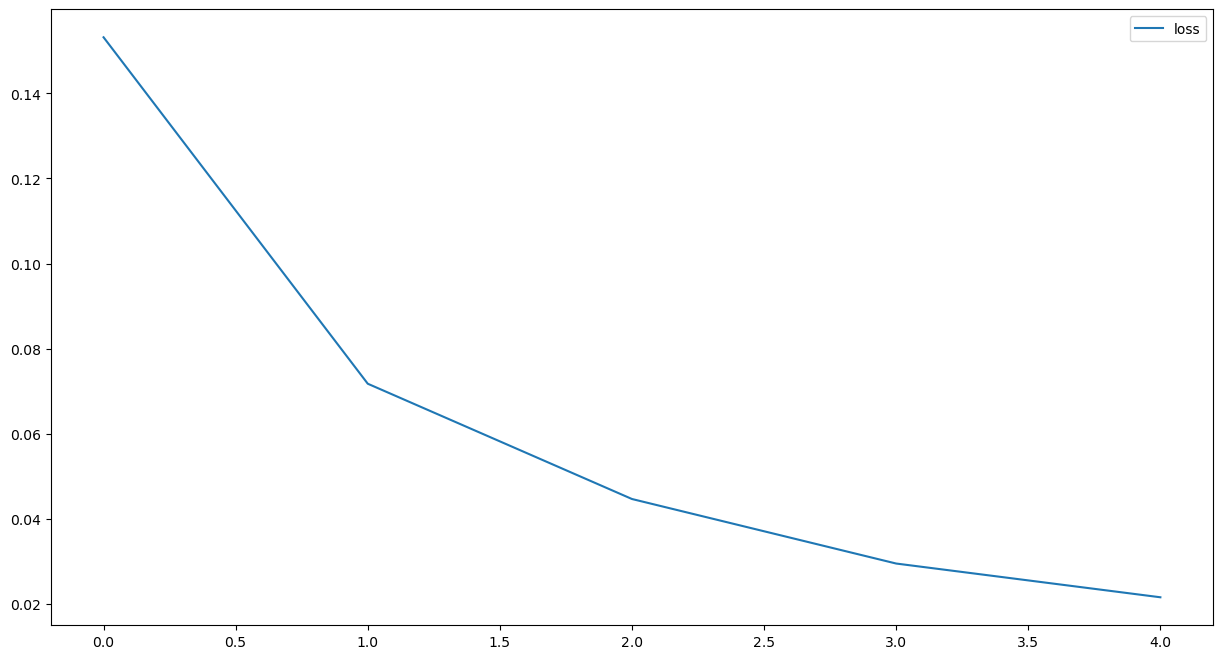

In [55]:
plt.figure(figsize=(15,8))
plt.plot(results.history['loss'], label='loss')
#plt.plot(results.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [32]:
cases, doses = instance_loader.testGen[0]
predictions = unet.predict(cases)

1/1 [==============================] - 3s 3s/step


In [34]:
case_index = 0

ptv = cases[case_index][:,:,:,1]
dose = doses[case_index][:,:,:,0]
pred_dose = predictions[case_index][:,:,:,0]

print(pred_dose.any())

err = tf.keras.losses.MeanAbsoluteError()(doses, predictions).numpy()
print('MAE', err)
CIndex = metrics.calc_conformity(ptv, pred_dose)
print('CI', CIndex)
HIndex = metrics.calc_homogeneity(pred_dose)
print('HI', HIndex)

False
MAE 0.0042029414
CI nan
HI nan


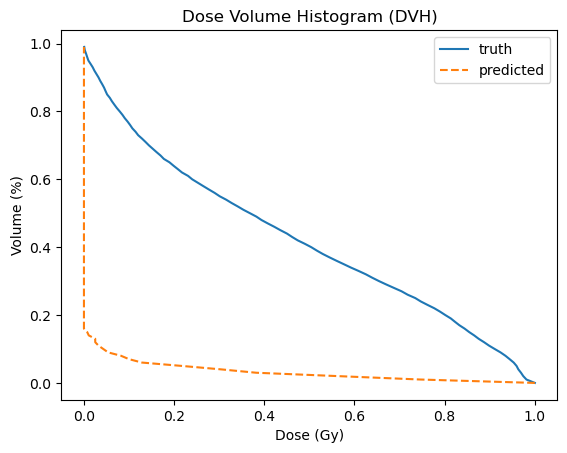

In [58]:
# Plot the DVH
dvh_values_truth, dvh_bins_truth = metrics.calc_DVH(dose)
dvh_values, dvh_bins = metrics.calc_DVH(pred_dose)

plt.plot(dvh_values_truth, dvh_bins_truth, label='truth')
plt.plot(dvh_values, dvh_bins, label='predicted', linestyle='dashed')
plt.xlabel("Dose (Gy)")
plt.ylabel("Volume (%)")
plt.title("Dose Volume Histogram (DVH)")
plt.legend()
plt.show()

In [ ]:
aa = dose[:,:,15]
ee = pred_dose[:,:,15]

for i in range(aa.shape[0]):
    for j in range(aa.shape[1]):
        print(str(round(aa[i][j], 1))[2], end='')
    print("\n", end='')
print('.')
for i in range(aa.shape[0]):
    for j in range(aa.shape[1]):
        print(str(round(ee[i][j], 1))[2], end='')
    print("\n", end='')

In [46]:
ct = cases[case_index][:,:,:,0]

biggest = np.max([ct.shape[-1], dose.shape[-1], pred_dose.shape[-1]])

interact(f2, x=(0, biggest-1), 
         ct=fixed(ct), oar=fixed(None), ptv=fixed(ptv), dose=fixed(dose), dose_threshold=fixed(0),
         ct2=fixed(ct), oar2=fixed(None), ptv2=fixed(ptv), dose2=fixed(pred_dose), dose_threshold2=fixed(0)
        )

interactive(children=(IntSlider(value=15, description='x', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x, ct, oar, ptv, dose, ct2, oar2, ptv2, dose2, dose_threshold=0, dose_threshold2=0)>